In [2]:
import numpy as np
from tqdm import tqdm
import random
from system import (
    states,
    s_state,
    actions,
    t_state, 
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    get_valid_actions,
    rows,
    cols
)
from model import Model
from policy import Policy, PolicyInit
from agent import Agent

In [3]:
def ch_egreedy(epsilon, Q, s):
    p = np.zeros(num_actions)
    valid_actions = get_valid_actions(s, idx=True)
    va = len(valid_actions)
    # print(va)
    p[valid_actions] = epsilon / va

    validqsa = Q[to_idx(s)][valid_actions]
    p[valid_actions[np.argmax(validqsa)]] += 1 - epsilon
    choice = np.random.choice(np.arange(num_actions), p=p)
    return choice

In [4]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)

model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

agent = Agent(model, policy)

In [5]:
def Egreedy_geneps(T: int, eps, Q_val: np.ndarray, start_state: np.ndarray, model: Model):
        estate = [start_state]
        start_action = ch_egreedy(eps, Q_val, start_state)
        eaction = [start_action]
        ereward = [
            model.get_reward(
                start_state, model.gen_next(start_state, start_action)
            )
        ]
        for i in range(T):
            estate.append(model.gen_next(estate[-1], eaction[-1], astuple=True))
            eaction.append(ch_egreedy(eps, Q_val, estate[-1]))
            ereward.append(model.get_reward(estate[-2], estate[-1]))
            if ereward[-1] == model.get_reward(estate[-2], t_state):
                break
        return estate, eaction, ereward

In [19]:
Q_val = np.random.uniform(-10, -1, (num_states, num_actions))
Q_val[to_idx(t_state)][:] = 0
episodic_reward = []

Ts = 100
gamma = 0.9
alpha = 0.1
epsilon = 0.3
lambda_ = 0.2
for i in tqdm(range(1000)):
    state = s_state 
    while True:
        estates, eactions, erewards = Egreedy_geneps(Ts, epsilon, Q_val, state, model)
        T = len(erewards)
        
        sr = 0
        sv = 0
        g = 0
        pwl = lambda_
        for j in range(1, T):
            # s = tuple(estates[T - j - 1])
            s = estates[T - j - 1]
            a = eactions[T - j - 1]
            r = erewards[T - j - 1]
            ns = estates[T - j]
            na = eactions[T - j]
            sr = sr * lambda_ + r*(1 - pwl)
            # print(sv * gamma * lambda_ + Q_val[to_idx(s)][a])
            sv = sv * gamma * lambda_ + Q_val[to_idx(ns)][na]
            g = sr + gamma*(1 - lambda_)*sv
            Q_val[to_idx(s)][a] = Q_val[to_idx(s)][a] + alpha * (g - Q_val[to_idx(s)][a])
            pwl = pwl * lambda_

        
        state = estates[1]
        if (state == t_state).all():
            break
    episodic_reward.append(np.max(Q_val[to_idx(s_state)][get_valid_actions(s_state, idx=True)]))


100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]


In [20]:
valf = []
for s in states:
    valid_actions = get_valid_actions(s, idx=True)
    valf.append(np.max(Q_val[to_idx(s)][valid_actions]))
valf = np.array(valf)

for s in states: 
    valid_actions = get_valid_actions(s, idx=True)
    action = valid_actions[np.argmax(Q_val[to_idx(s)][valid_actions])]
    policy.set_action(s, action)
agent.change_policy(policy)

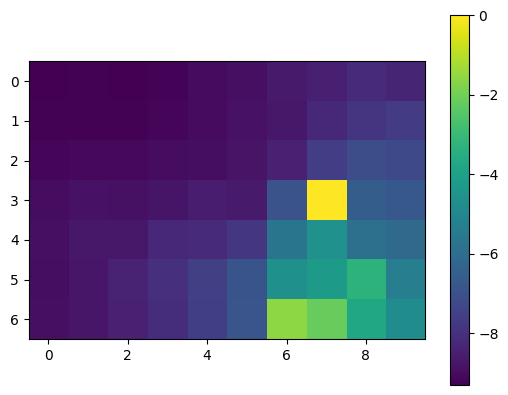

In [21]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

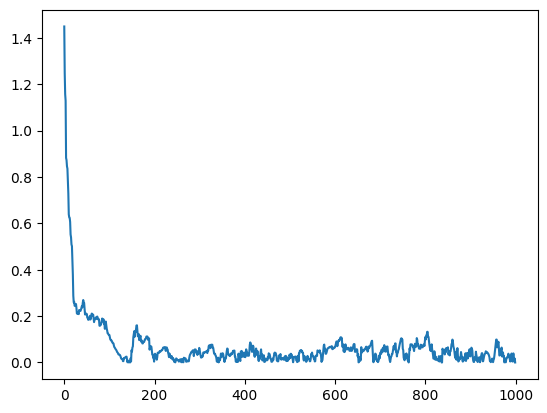

In [22]:
episodic_regret = np.abs(episodic_reward - valf[to_idx(s_state)])
plt.plot(episodic_regret)

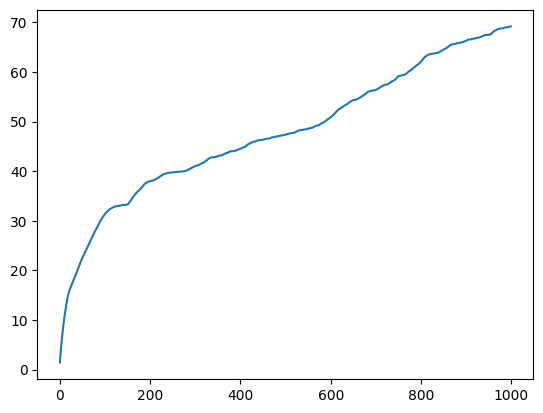

In [23]:
cummulative_regret = np.cumsum(episodic_regret)
plt.plot(cummulative_regret)

In [27]:
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [1 1], Next State: [4 1], Reward: -1
State: [4 1], Action: [1 1], Next State: [5 2], Reward: -1
State: [5 2], Action: [1 1], Next State: [5 3], Reward: -1
State: [5 3], Action: [1 1], Next State: [5 4], Reward: -1
State: [5 4], Action: [1 1], Next State: [6 5], Reward: -1
State: [6 5], Action: [0 1], Next State: [5 6], Reward: -1
State: [5 6], Action: [0 1], Next State: [3 7], Reward: 0
Game Over - Score: -6


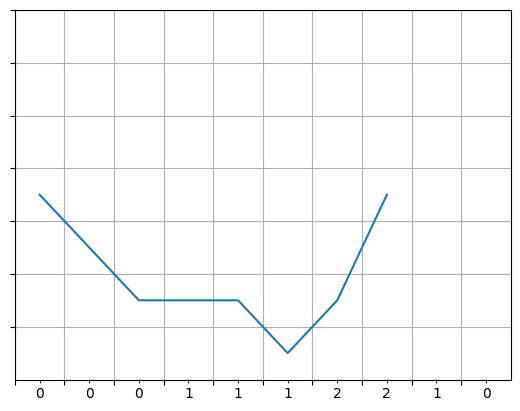

In [28]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()